In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from neurodsp.sim import sim_variable_oscillation, sim_powerlaw
from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra
from neurodsp.filt import filter_signal
from neurodsp.sim.periodic import make_bursts, make_is_osc_prob

from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum

from ndspflow.motif import Motif

In [454]:
np.random.seed(0)

# skew_neg, skew_pos, uniform, norm
dist_type = 'skew_pos'
dist_type = 'norm'
def random_dist(dist_type):
    
    if dist_type.startswith('skew'):
        skew = 50

        if dist_type.endswith('neg'):
            skew *= -1

        freqs_sim = sp.stats.skewnorm.rvs(skew, size=1000)
        freqs_sim *= 3
        freqs_sim -= freqs_sim.mean()
        freqs_sim += 20

        plt.hist(freqs_sim, bins=50)
        plt.show()

    elif dist_type == 'norm':

        freqs_sim = np.random.normal(20, 1, 1000)
        plt.hist(freqs_sim, bins=50)
        plt.show()

    elif dist_type == 'uniform':

        freqs_sim = np.random.uniform(16, 24, 1000)

        plt.hist(freqs_sim, bins=50)
        plt.show()
        
    elif dist_type == 'u':
        # Inverted normal (u-shaped)
        _freqs = np.linspace(16, 25, 200)

        probs = 2 ** (np.abs(_freqs - _freqs.mean())+1)
        probs /= probs.sum()

        probs.sum()

        freqs_sim = np.random.choice(_freqs, size=1000, p=probs)

        plt.hist(freqs_sim, bins=100)
        plt.show()
        
    return freqs_sim

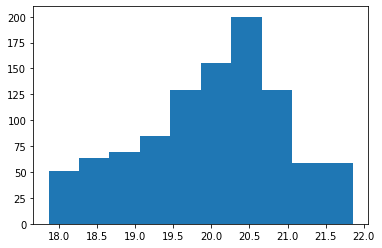

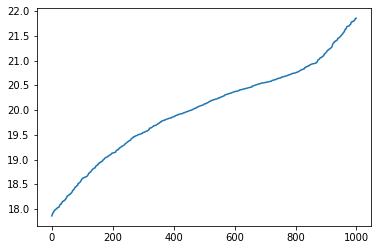

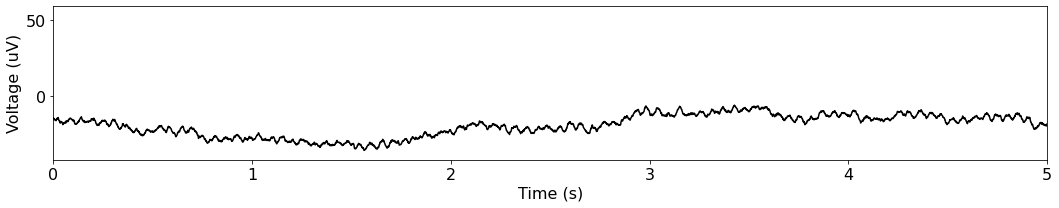

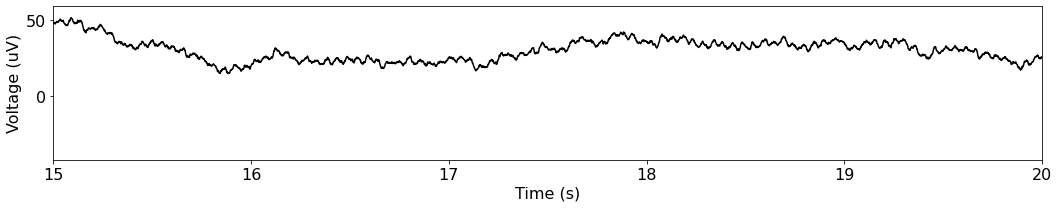

In [72]:
np.random.seed(0)

norm_ratio = 0.5
norm_samples = np.ceil(norm_ratio * 1000).astype(int)
unif_samples = np.floor((1-norm_ratio) * 1000).astype(int)

#freqs_sim = np.random.normal(20, 1, norm_samples)
skew = -10
freqs_sim = sp.stats.skewnorm.rvs(skew, size=norm_samples)
#freqs_sim *= 3
freqs_sim = np.append(
    freqs_sim,
    np.random.uniform(np.floor(freqs_sim.min()), np.ceil(freqs_sim).max(),
                      unif_samples)
)

freqs_sim -= freqs_sim.mean()
freqs_sim += 20

plt.hist(freqs_sim)
plt.show()

freqs_sim = freqs_sim[freqs_sim.argsort()]

plt.plot(freqs_sim)
plt.show()

fs = 1000

sig = sim_variable_oscillation(None, fs, freqs_sim, phase='min')

"""
# Determine start/end indices
cyc_lens = [int(np.ceil(1 / freq * fs)) for freq in freqs_sim]
ends = np.cumsum(cyc_lens, dtype=int)
starts = [0, *ends[:-1]]

is_bursts = make_is_osc_prob(len(freqs_sim), .25, .5)

for is_burst, start, end in zip(is_bursts, starts, ends):
    if not is_burst:
        sig[start:end] = 0
"""
sig += sim_powerlaw(1, len(sig)) * 20
times = np.arange(0, len(sig)/fs, 1/fs)

plot_time_series(times, sig, xlim=(0, 5))
plot_time_series(times, sig, xlim=(15, 20))


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



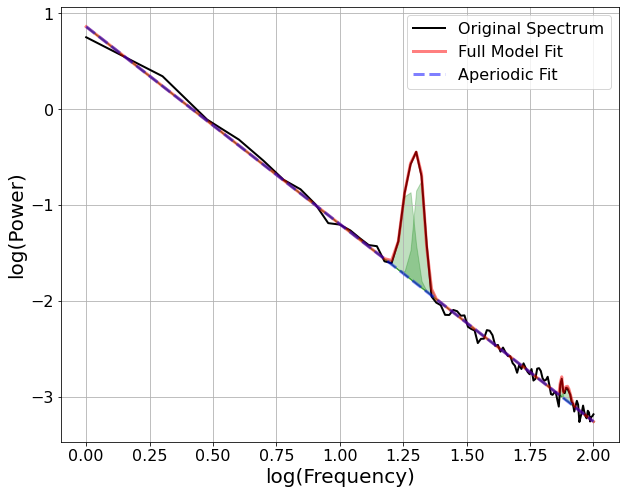

In [62]:
freqs, powers = compute_spectrum(sig, fs)

# SpecParam
fm = FOOOF()

fm.fit(freqs, powers, freq_range=(1, 100))

fm.plot(plot_peaks='shade', plt_log=True)


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



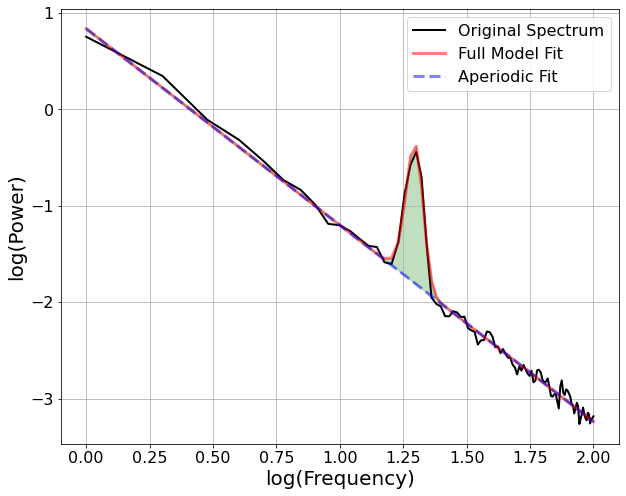

In [60]:
freqs, powers = compute_spectrum(sig, fs)

# SpecParam
fm = FOOOF(max_n_peaks=1)

fm.fit(freqs, powers, freq_range=(1, 100))

fm.plot(plot_peaks='shade', plt_log=True)

In [63]:
motif = Motif(min_clust_score=0.5, corr_thresh=.25, var_thresh=0)
motif.fit(fm, sig, fs)
motif.plot()

/home/voytek/projects/neurodsp/neurodsp/filt/checks.py:172: UserWarning:

Transition bandwidth is 5.2 Hz. This is greater than the desired pass/stop bandwidth of 4.2 Hz

/home/voytek/projects/neurodsp/neurodsp/filt/checks.py:172: UserWarning:

Transition bandwidth is 5.2 Hz. This is greater than the desired pass/stop bandwidth of 4.2 Hz

/home/voytek/projects/neurodsp/neurodsp/filt/checks.py:172: UserWarning:

Transition bandwidth is 6.0 Hz. This is greater than the desired pass/stop bandwidth of 3.9 Hz



(array([63., 23., 22., 39., 93., 38., 52., 48., 40., 46.]),
 array([16.66666667, 17.04081633, 17.41496599, 17.78911565, 18.16326531,
        18.53741497, 18.91156463, 19.28571429, 19.65986395, 20.03401361,
        20.40816327]),
 <BarContainer object of 10 artists>)

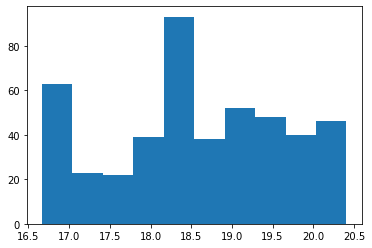

In [68]:
plt.hist(fs / motif[0].df_features['period'].values)

(array([38., 54., 49., 39., 48., 42.,  0., 38., 40., 40.]),
 array([18.86792453, 19.2033543 , 19.53878407, 19.87421384, 20.20964361,
        20.54507338, 20.88050314, 21.21593291, 21.55136268, 21.88679245,
        22.22222222]),
 <BarContainer object of 10 artists>)

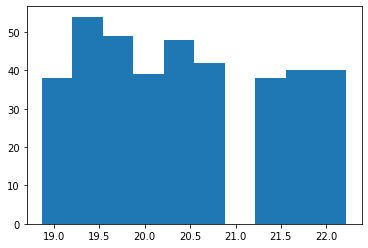

In [69]:
plt.hist(fs / motif[1].df_features['period'].values)